## Setup

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm
import statsmodels.tsa as tsa
import os, sys
path = os.path.abspath(os.path.join('..'))
if path not in sys.path:
    sys.path.append(path)

from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso, Ridge, LassoCV, RidgeCV, LogisticRegression, LinearRegression
from sklearn.model_selection import TimeSeriesSplit, train_test_split, GridSearchCV, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import precision_recall_curve, roc_curve, confusion_matrix, f1_score, make_scorer, mean_squared_error
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier, DummyRegressor

from eptest_main import read_ep_data, get_ct_dfs, adjust_ct_dfs, get_rolling_cts, get_interp_swaps
from eptest_main import test_adfuller, RegressionMain, get_norm_curve_diffs
from eptest_main import CT_SWAP_MAP, CT_SIZES, COT_COLS, PRICE_DUR_COLS
from Modelling.classification import *

legacy, tff, futures, swaps_raw = read_ep_data()
swaps = get_interp_swaps(swaps_raw)

In [2]:
futures['FV'].head()

field,PX_LAST,FUT_EQV_DUR_NOTL,OPEN_INT
2010-01-01,115.492188,4.4430,11938
2010-01-04,114.546875,4.4403,748097
2010-01-05,114.945312,4.4415,759207
2010-01-06,114.906250,4.4414,776474
2010-01-07,114.796875,4.4410,783076


In [3]:
idx = pd.IndexSlice
futures.loc[:, idx[:, 'PX_LAST']].tail()

ct,TU,FV,TY,US,WN
field,PX_LAST,PX_LAST,PX_LAST,PX_LAST,PX_LAST
2020-10-14,110.437500,125.890625,139.218750,175.37500,220.15625
2020-10-15,110.437500,125.843750,139.125000,175.25000,219.84375
2020-10-16,110.429688,125.820312,139.062500,174.90625,218.93750
2020-10-19,110.425781,125.757812,138.921875,174.50000,218.25000
2020-10-20,110.425781,125.718750,138.703125,173.50000,215.81250


In [4]:

# look at historical CTD mty?
# wish i could get invoice spreads data more easily

# break the data as of measurement for initial modeling purposes
ct_dfs = get_ct_dfs(legacy, tff, futures, swaps)

ct_dfs['US'].head()


,Com,NonCom,NonRep,AM,LevFunds,Dealers,OtherRep,PX_LAST,FUT_EQV_DUR_NOTL,OPEN_INT,swap_US
2010-01-01,115151.0,-103690.0,-11461.0,327844.0,-157049.0,-155350.0,-3984.0,115.37500,12.4921,670420.0,4.3458
2010-01-04,115151.0,-103690.0,-11461.0,327844.0,-157049.0,-155350.0,-3984.0,115.09375,12.4824,667206.0,4.3372
2010-01-05,123354.0,-101533.0,-21821.0,327142.0,-152979.0,-146571.0,-5771.0,116.03125,12.5146,658779.0,4.2645
2010-01-06,123354.0,-101533.0,-21821.0,327142.0,-152979.0,-146571.0,-5771.0,115.31250,12.4900,659893.0,4.3355
2010-01-07,123354.0,-101533.0,-21821.0,327142.0,-152979.0,-146571.0,-5771.0,115.28125,12.4889,651459.0,4.3520


In [5]:
# function to compute dv01 weighted values and shift CoT data 3d forward after

adj_ct_dfs = adjust_ct_dfs(ct_dfs, swaps, oi_avg_len=125)

adj_ct_dfs['TY'].head()



,Com,NonCom,NonRep,AM,LevFunds,Dealers,OtherRep,Com_dv01,Com_pctAvgOI,NonCom_dv01,...,NonRep_pctAvgOI,AM_dv01,AM_pctAvgOI,LevFunds_dv01,LevFunds_pctAvgOI,Dealers_dv01,Dealers_pctAvgOI,OtherRep_dv01,OtherRep_pctAvgOI,7y
2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.5285
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.4801
2010-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.3975
2010-01-06,171617.0,-136356.0,-35261.0,99582.0,-50214.0,-80946.0,66839.0,1.555238e+07,NaN,-1.235694e+07,...,NaN,9.024382e+06,NaN,-4.550524e+06,NaN,-7.335539e+06,NaN,6.057125e+06,NaN,3.4545
2010-01-07,171617.0,-136356.0,-35261.0,99582.0,-50214.0,-80946.0,66839.0,1.556449e+07,NaN,-1.236656e+07,...,NaN,9.031409e+06,NaN,-4.554068e+06,NaN,-7.341251e+06,NaN,6.061842e+06,NaN,3.4765


In [6]:
# resample on Friday's with 'window' sized rolling weekly differences
feat_adj = '_dv01'
window = 26
r = get_rolling_cts(adj_ct_dfs, feat_adj, window=window, swap_chg_lags=[1,2])

# determine stationarity of features
for k, df in r.items():
    print(k, test_adfuller(df, maxlag=1))
for k, df in r.items():
    print(k, df.corr())
r['US'].head(10)

C:\Users\Brendan\FinML\MLFin\ExPtTest\eptest_main.py:192: RuntimeWarning: invalid value encountered in sign
  new_df[ind] = (np.sign(new_df[col])!=np.sign(new_df[first_swap])).astype(int)


FV                              tstat          pval
Com_dv01                 -4.375874  3.274151e-04
NonCom_dv01              -4.383096  3.179611e-04
NonRep_dv01              -5.839627  3.804264e-07
AM_dv01                  -3.050912  3.040568e-02
LevFunds_dv01            -3.552189  6.743676e-03
Dealers_dv01             -4.182056  7.065291e-04
OtherRep_dv01            -3.416817  1.039876e-02
5y                       -2.930875  4.187367e-02
Com_ind                  -8.365545  2.749332e-13
Com_dv01_rightsign       -7.009535  6.979612e-10
NonCom_ind               -7.962352  2.925649e-12
NonCom_dv01_rightsign    -4.204059  6.485524e-04
NonRep_ind              -10.290437  3.581854e-18
NonRep_dv01_rightsign    -5.414116  3.163481e-06
AM_ind                   -7.078363  4.736761e-10
AM_dv01_rightsign        -5.063616  1.658325e-05
LevFunds_ind             -7.416105  6.928849e-11
LevFunds_dv01_rightsign  -4.165442  7.534988e-04
Dealers_ind              -8.443726  1.735291e-13
Dealers_dv01_righ

,Com_dv01,NonCom_dv01,NonRep_dv01,AM_dv01,LevFunds_dv01,Dealers_dv01,OtherRep_dv01,swap_US,Com_ind,Com_dv01_rightsign,...,LevFunds_ind,LevFunds_dv01_rightsign,Dealers_ind,Dealers_dv01_rightsign,OtherRep_ind,OtherRep_dv01_rightsign,swap_US_lag26,swap_US_fwd26,swap_US_lag52,swap_US_fwd52
2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,...,1,NaN,1,NaN,1,NaN,NaN,-0.8688,NaN,0.3595
2010-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,...,1,NaN,1,NaN,1,NaN,NaN,-0.8265,NaN,0.3538
2010-01-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,...,1,NaN,1,NaN,1,NaN,NaN,-0.8335,NaN,0.4995
2010-01-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,...,1,NaN,1,NaN,1,NaN,NaN,-0.7152,NaN,0.5087
2010-01-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,...,1,NaN,1,NaN,1,NaN,NaN,-0.7700,NaN,0.5552
2010-02-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,...,1,NaN,1,NaN,1,NaN,NaN,-0.7915,NaN,0.8805
2010-02-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,...,1,NaN,1,NaN,1,NaN,NaN,-1.1500,NaN,1.0993
2010-02-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,...,1,NaN,1,NaN,1,NaN,NaN,-1.3024,NaN,1.1181
2010-02-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,...,1,NaN,1,NaN,1,NaN,NaN,-1.0897,NaN,0.9260
2010-03-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,...,1,NaN,1,NaN,1,NaN,NaN,-1.0986,NaN,0.9739


## TY Lasso may have something

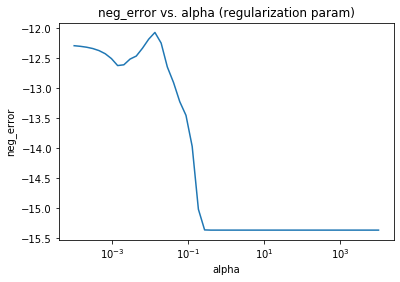

beta                [-0.14832437222174355, 0.06233281161825258, -0...
best_score                                                   -12.0673
alpha                                                       0.0132571
best_score_ratio                                             0.785437
Name: TY, dtype: object

In [7]:
# simple crossvalidation to evaluate if theres anything here outright

is_start_dt = dt.date(2012, 1, 1)
ct = 'TY'
unadj_feat = ['AM', 'LevFunds', 'OtherRep', 'Com', 'NonCom']
model = Lasso()

swap = CT_SWAP_MAP[ct][0]
target = swap+'_fwd'+str(window)
num_features = np.hstack([[a+feat_adj for a in unadj_feat], swap])
search, output_df = run_cv(r, ct, window, feat_adj, is_start_dt, num_features, target, tss_splits=20,
                              model=Lasso(), model_type='Regression', hyperparam_name='alpha',
                              scorer=None, sample_weight=None, max_train_size=208)
display_cv_metrics(search, 'alpha', 'neg_error', log_scale=True)
output_df
##
# WE NEED TO NORMALIZE THESE FEATURES FIRST BEORE USING REGULARIZATION
# START WITH SKLEARN THEN WE CAN MOVE ONTO OUR OWN transform/inv transform IMPLEMENTATION TO RETRIEVE PREDICTIONS
##
# pred, dates, betas = RegressionMain(r[ct], target, features, 13, 'Ridge', embargo_size=0,
#                                    max_train_size=26, logpx=False, ewm_span=None, verbose=True, alpha_override=None)
# betas_df = pd.DataFrame(betas, index=dates, columns=['const']+features)
# resid = r[ct].loc[:, target] - pred

# fig, ax = plt.subplots(nrows=2)
# betas_df.plot(ax=ax[0])
# resid.plot(ax=ax[1])
# plt.show()

## Curve
ToDo
- generate all curve combos
- generate features (differences raw and zscore) and targets
- run similar to above 

C:\Users\Brendan\FinML\MLFin\ExPtTest\eptest_main.py:192: RuntimeWarning: invalid value encountered in sign
  new_df[ind] = (np.sign(new_df[col])!=np.sign(new_df[first_swap])).astype(int)


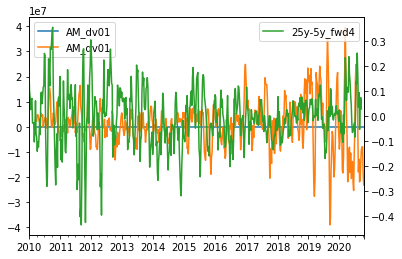

In [12]:
from itertools import combinations
curves = ([c for c in combinations(CT_SIZES.keys(), 2)])

# resample on Friday's with 'window' sized rolling weekly differences
feat_adj = '_dv01'
window = 4
r = get_rolling_cts(adj_ct_dfs, feat_adj, window=window, swap_chg_lags=[1])
curve_diffs = get_norm_curve_diffs(curves, r, window)

fig, ax = plt.subplots()
curve_diffs['WN-FV'].loc[:, 'AM_dv01'].rolling(1).sum().plot(ax=ax)
r['WN'].loc[:, 'AM_dv01'].rolling(1).sum().plot(ax=ax)
ax2 = curve_diffs['WN-FV'].loc[:, '25y-5y_fwd'+str(window)].rolling(1).sum().plot(ax=ax, secondary_y=True)
ax.legend(), ax2.legend()

plt.show()


In [24]:
# run all and aggregate data up
is_start_dt = dt.date(2012, 1, 1)
unadj_feat = ['AM', 'LevFunds', 'OtherRep', 'Com', 'NonCom']
model = Lasso()

outputs = {}
searches = {}
for curve_tup in curves:
    curve = '-'.join(list(reversed(curve_tup)))
    swap_curve = '-'.join([CT_SWAP_MAP[a][0] for a in curve.split('-')])
    target = swap_curve#+'_fwd'+str(window)
    target_lag = swap_curve+'_lag'+str(window)
    num_features = np.hstack([[a+feat_adj for a in unadj_feat], target_lag])
    search, output_srs = run_cv(curve_diffs, curve, window, feat_adj, is_start_dt, num_features, target, tss_splits=10,
                                  model=model, model_type='Regression', hyperparam_name='alpha',
                                  scorer=None, sample_weight=None, max_train_size=208)
    outputs[curve] = output_srs
    searches[curve] = search
output_df = pd.concat(outputs, axis=1)
output_df

,FV-TU,TY-FV,TY-TU,US-FV,US-TU,US-TY,WN-FV,WN-TU,WN-TY,WN-US
beta,"[-0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[-0.0, 0.0, 0.0, 0.0, -0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, -0.0, 0.0]","[-0.0, 0.0, 0.0, 0.0, -0.0, 0.0]","[0.0, -0.0, 0.0, 0.0, -0.0, 0.0]","[-0.0, 0.0, 0.0, 0.0, -0.0, -0.0]","[-0.0, 0.007376362571570089, 0.014200471089889...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, -0.0, 0.0, 0.0, -0.0, -0.0]","[0.0, -0.0, 0.0, 0.0, -0.0, -0.0]"
best_score,-0.38004,-0.237283,-0.444538,-0.187862,-0.376703,-0.175373,-0.178453,-0.348281,-0.14186,-0.183043
alpha,0.019307,0.019307,0.0409492,0.019307,0.0409492,0.019307,0.0132571,0.0868511,0.0409492,0.00910298
best_score_ratio,0.904958,0.836318,1,0.819689,0.932976,0.839235,0.867458,0.902182,0.767905,0.988342


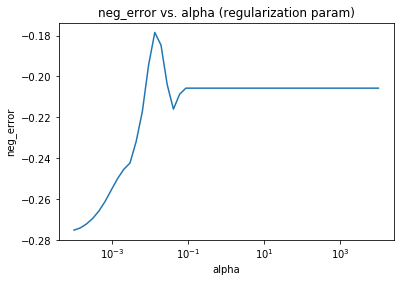

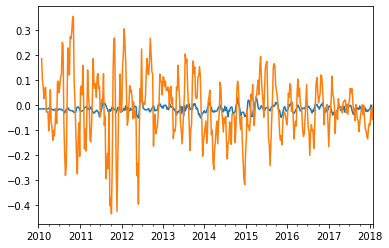

In [28]:
# test one
is_start_dt = dt.date(2012, 1, 1)
curve = 'WN-FV'
unadj_feat = ['AM', 'LevFunds', 'OtherRep', 'Com', 'NonCom']
model = Lasso()

swap_curve = '-'.join([CT_SWAP_MAP[a][0] for a in curve.split('-')])
target = swap_curve#+'_fwd'+str(window)
target_lag = swap_curve+'_lag'+str(window)
num_features = np.hstack([[a+feat_adj for a in unadj_feat], target_lag])
search, output_df = run_cv(curve_diffs, curve, window, feat_adj, is_start_dt, num_features, target, tss_splits=10,
                              model=Lasso(), model_type='Regression', hyperparam_name='alpha',
                              scorer=None, sample_weight=None, max_train_size=208)
display_cv_metrics(search, 'alpha', 'neg_error', log_scale=True)

X = curve_diffs[curve].loc[:, num_features]
y = curve_diffs[curve].loc[:, target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)
pred = pd.Series(search.predict(X_train), index=X_train.index)
pred.plot()
y_train.plot()

In [15]:
curves

[('TU', 'FV'),
 ('TU', 'TY'),
 ('TU', 'US'),
 ('TU', 'WN'),
 ('FV', 'TY'),
 ('FV', 'US'),
 ('FV', 'WN'),
 ('TY', 'US'),
 ('TY', 'WN'),
 ('US', 'WN')]

# ToDo

## Data
### General
    - Check for general numerical issues
        - US June 2015 contract had a delivery gap of ~5yrs relative to March15 due to tsy issuance in early 2000s
        - see: https://www.cmegroup.com/trading/interest-rates/files/mar-15-jun-15-roll-analysis.pdf
        - the CTD MM swap then gets closer to the 20y... consider interpolating
    - Create offset series for Fridays, lets just shift it 3 days (data stamped tuesday but reported friday+ if holiday)
    - Split train+cv and full test data. Test data lets do 2010-2011 and Oct. 2018+
### Feature Generation:
Start evaluating training data visually, we need to work on stationary time series so let's do the transforms upfront:
        - DV01-weighted positions or % OI will be more informative, dur*px/100*ct_size/10000
        - Rolling x-week changes in transformed CoT data
            - Consider PCA of this CoT data and look at consistency of loadings over time
        - Rolling x-week changes in swap data
        - Indicator variables of whether the CoT change was 'same-way' as market move
    
    

## (this is done, just have to backtest TYs) 
## Modelling
### Feature Selection
Let's do feature selection second- random forest type feature importance algos, lasso
- First pass we can look at a few sets of x-lagged 1m changes(e.g. 1m lagged 1m changes, 2m lagged 1m changes, etc)
    
### Regression
Features need to be fit on a weekly basis- this data is weekly
- We could consider either modeling on Tuesday data or Friday, but need to evaluate residuals based on Friday
- Residual evaluation can be daily, not sure how valuable that'd be
Simple setups first
- lagged aggregated changes, including conditional on same way stuff
More complicated
- Maybe we do our own type of gridsearch CV with the parameter being the length of the window to aggregate changes

## Modelling
### Curve
- differences in rolling (raw and z-scored) increases to predict subsequent curve
    - construct all the pairwise combinations
    - compute features and targets
    - run the same process as above with outrights
- try predicting signs rather than regressions next

## Presentation
### Data
- bar charts of ADF p-values
- neg mse vs ridge alpha plot

## Extra Credit
Can we use some classification algorithms to filter when to trade or not to trade